# Math and optics research for ray tracing package

Francis Deck, 8-17-2023

This is where I'm going to put all of my sources for the math and optics used in my ray tracing program.

In [1]:
# %matplotlib notebook
from copy import copy, deepcopy

import matplotlib.pyplot as plt
import numpy as np

run_tests = True

## Math needs

In [2]:
def norm(x):
    # Length of vector x
    return np.sqrt(np.sum(x**2))


def radius(x):
    # distance of a point from the z axis
    return norm(x * np.array([1, 1, 0]))


def normalize(v):
    # Force a vector to be a unit vector
    return v / norm(v)

In [3]:
def sag_conic(R, c, k):
    """
    sag function for conic section surface
    R = distance from centerline
    c = curvature 1/ROC
    k = conic constant, 0 for sphere, -1 for parabola
    """
    return c * R**2 / (1 + np.sqrt(1 - (1 + k) * c**2 * R**2))


def d_sag_d_R2(R, c, k):
    """
    derivative of sag with respect to R^2, automatically generated by WxMaxima
    """
    R2 = R**2
    return (
        c / (np.sqrt(1 - R2 * c**2 * (k + 1)) + 1)
        + (
            (R2 * c**3 * (k + 1))
            / (
                np.sqrt(1 - R2 * c**2 * (k + 1))
                * (np.sqrt(1 - R2 * c**2 * (k + 1)) + 1) ** 2
            )
        )
        / 2
    )

### Distance from a point to a line

https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line

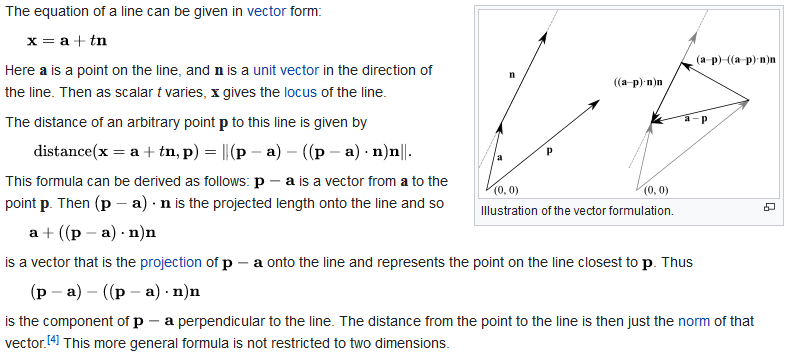

### Intersection of a line and a plane

https://en.wikipedia.org/wiki/Line%E2%80%93plane_intersection

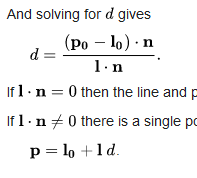 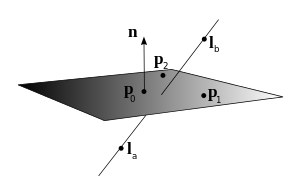

### Coordinate transformations

https://www.haroldserrano.com/blog/rotations-in-computer-graphics

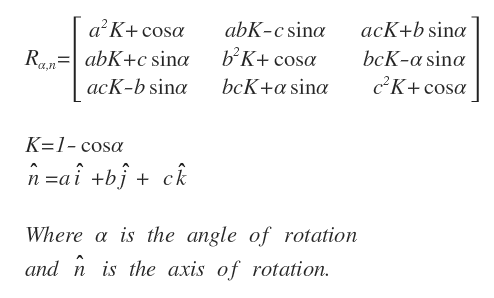

## Propagation of rays through refractive surface

I don't know who wrote this derivation, I found the image in a Google search, and it checks out.

https://image.slidesharecdn.com/raytracing-111026083006-phpapp01/95/ray-tracing-23-728.jpg

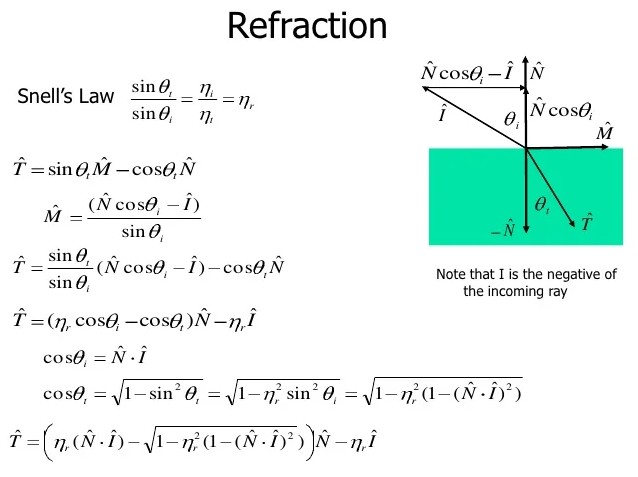

A second source at least is of known origin:

https://web.cse.ohio-state.edu/~shen.94/681/Site/Main.html

The slides on reflection and refraction are at: 

https://web.cse.ohio-state.edu/~shen.94/681/Site/Slides_files/reflection_refraction.pdf

The derivation sets up a coordinate basis $\hat M$ and $\hat N$, then composes the refracted ray $\hat T$ in terms of those coordinates.

How we trace the intersection to a conic surface:

Standard conic section sag equation (look up anywhere):

$z(r) = \dfrac {c r^2} {1 + \sqrt{1 - (1 + k)c^2r^2}}$

$r$ = distance from z axis

$c$ = curvature, i.e., reciprocal of radius-of-curvature

$k$ = conic constant, zero for sphere, -1 for parabola

Intersection of a ray with the surface is done iteratively:

1. Compute r and sag, trace ray to plane $z$ = sag
2. Re-compute r and sag, trace ray to new $z$ = sag
3. For now, good enough to just repeat this 10 times

For tracing through the interface by refraction, I followed the derivation in this slide. I don't know where this slide came from, so I'll copy the graphic here.

For rotationally symmetric function of $r^2$,

$\dfrac {\partial z(x, y)} {\partial x} = \dfrac {\partial z(r^2)}{\partial r^2} \dfrac {\partial r^2} {\partial x} =   2x\dfrac {\partial z(r^2)}{\partial r^2}$ ,likewise for $y$.

I computed $\dfrac {\partial z(r^2)}{\partial r^2}$ using wxMaxima. Later on I'd like to do this within the notebook using SymPy.

Here's the wxMaxima code for generating the derivative. WxMaxima doesn't produce Python output, but Fortran is easy enough to translate by hand:

    sag: c*R2/(1 + sqrt(1 - (1+k)*c^2*R2));
	fortran(diff(sag,R2,1));

## Propagation of rays through diffraction grating

Grating. Equation 6.7 from here:

https://www.lambdares.com/wp-content/uploads/support/oslo/oslo_edu/oslo-optics-reference.pdf

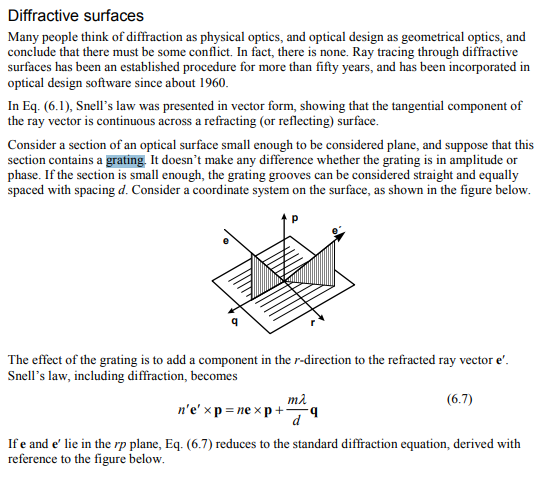

The grating equation as shown is completely general:

$n' \hat e' \times \hat p = n \hat e \times p + \dfrac {m \lambda} {d} \hat q$

However, for a plane grating, normal to the optical axis, and with grooves parallel to the x axis, it can be simplified by letting $\hat p = \hat k$ and $\hat q = \hat i$

Using the traditional formula for the cross product:

$\vec{a} \times \vec{b} = (a_2b_3-a_3b_2)i + (a_3b_1-a_1b_3)j+(a_1b_2-a_2b_1)k$

The general grating equation reduces to:

$n'(e'_y \hat x + e'_x \hat y) = n (e_y \hat x + e_x \hat y) + \dfrac {m \lambda} d \hat x$

Collecting like terms,

$e'_y = \dfrac 1 {n'}(n e_y + \dfrac {m \lambda)} d)$

$e'_x = \dfrac n {n'} e_x$

The simplification is acceptable because any other orientation of the grating can be handled with coordinate breaks.

As for concave gratings, my experience is that they are un-modelable. The reason is that concave holographic gratings tend to be quite specialized, and often have non-parallel grooves due to aberration corrections applied during the writing of the hologram. And the makers of these gratings can be reluctant to share their model data.

## Propagation of rays through "paraxial" surface.

11-23-2023

This turned out to be really easy. I did find a reference online to a method, but it seems complex. On the other hand, it did provide the valuable insight.

https://apps.dtic.mil/sti/pdfs/ADA428762.pdf

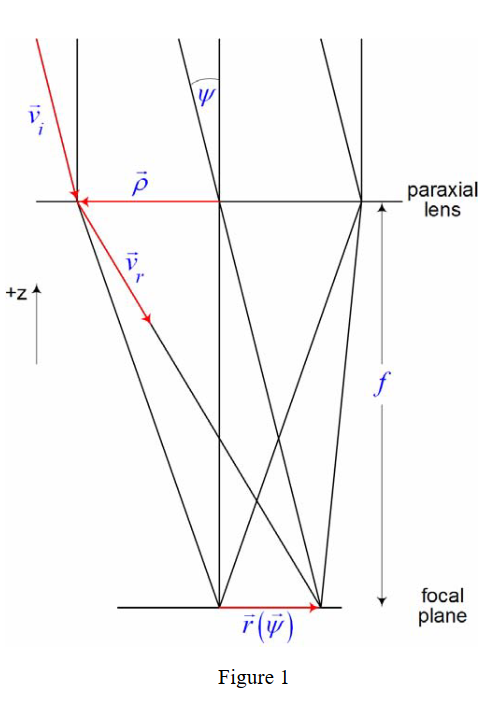

The definition of this thing called a "paraxial" lens, is that *all rays parallel to the chief ray pass through a single point in the focal plane*. Thus for each incoming ray, tracing through the paraxial can be done in the following steps:

0. Find the intersection of the incoming ray with the paraxial surface.

1. Find the chief ray. This is the ray parallel to the incoming ray, but passing through the center of the surface.

2. Trace the chief ray by a distance equal to the focal length of the surface, to the focal point. The incoming ray will also pass through this focal point.

3. The outgoing ray vector is the vector pointing from the intersection to the focal point.